<H3>PRI 2023/24: first project delivery</H3>

**GROUP 8**
- Daniele Avolio    , ist1111559
- Michele Vitale	, ist1111558	
- Luís Dias	        , ist198557

<H3>Part I: demo of facilities</H3>

A) **Indexing** (preprocessing and indexing options)

Initially, let's create a `function` to read the `documents` we need to analyze.

In [5]:
import os  

def read_files(location:str):
    filespath = []  
    
    for root, dirs, files in os.walk(location):
        for file in files:
            if file.endswith(".txt"): 
                filespath.append(os.path.join(root, file))  
    
    return filespath  

In [6]:
documents_paths = read_files("../BBC News Summary/News Articles")  
print(documents_paths[:5])
print(f"The number of documents is {len(documents_paths)}")

['../BBC News Summary/News Articles\\business\\001.txt', '../BBC News Summary/News Articles\\business\\002.txt', '../BBC News Summary/News Articles\\business\\003.txt', '../BBC News Summary/News Articles\\business\\004.txt', '../BBC News Summary/News Articles\\business\\005.txt']
The number of documents is 2225


Let's just plot the number of documents for each category

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_categories(documents_paths):    
    return [path.split("\\")[-2] for path in documents_paths]


def plot_categories(categories:list):
    sns.countplot(y=categories, palette="Set2", hue=categories, legend=False)
    plt.title("Number of documents per category")
    plt.show()


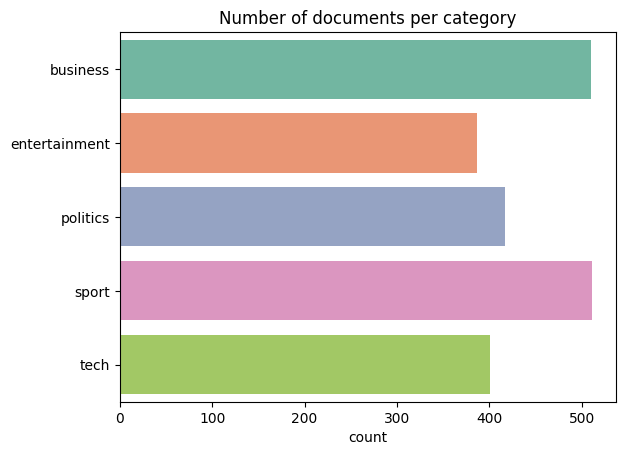

In [8]:
categories = get_categories(documents_paths)
plot_categories(categories)

Possible function to index

In [9]:
# code, statistics and/def
import os
import time
from whoosh import index, scoring
from whoosh.fields import Schema, TEXT, NUMERIC
from whoosh.analysis import StandardAnalyzer, StemFilter, LowercaseFilter, StopFilter

stoplist = frozenset(
    [
        "and",
        "is",
        "it",
        "an",
        "as",
        "at",
        "have",
        "in",
        "yet",
        "if",
        "from",
        "for",
        "when",
        "by",
        "to",
        "you",
        "be",
        "we",
        "that",
        "may",
        "not",
        "with",
        "tbd",
        "a",
        "on",
        "your",
        "this",
        "of",
        "us",
        "will",
        "can",
        "the",
        "or",
        "are",
    ]
)


def indexing(document_collection, stem=False, stop_words=True):
    start_time = time.time()

    # It's important to put the stoplist check here because in the constructor
    # of the StandardAnalyzer, the stoplist parameter is set automatically to a default
    # so if we want to remove it, we need to check it during the construction
    analyzer = StandardAnalyzer(stoplist=stoplist if stop_words else None)

    if stem:
        analyzer = analyzer | StemFilter()
    schema = Schema(
        id=NUMERIC(stored=True),
        content=TEXT(
            analyzer=analyzer,
            stored=True,
        ),
    )

    index_dir = "indexdirectory"
    if not os.path.exists(index_dir):
        os.mkdir(index_dir)

    ix = index.create_in(index_dir, schema)

    writer = ix.writer()

    for doc_id, document in enumerate(document_collection):
        with open(document, "r") as file:
            file.readline() #To skip the first line of the file
            content = file.read()
            writer.add_document(id=doc_id, content=content)
    writer.commit()

    indexing_time = time.time() - start_time

    return ix, indexing_time

In [10]:
from whoosh.qparser import QueryParser

ix, indexing_time = indexing(documents_paths)

print(f"Indexing time: {indexing_time} seconds")
print(f"Number of indexed documents: {ix.doc_count()}")

Indexing time: 30.29577350616455 seconds
Number of indexed documents: 2225


In [11]:
# Print the index indexes
from whoosh.reading import IndexReader

terms = ix.reader().all_terms()

print(list(terms))

[('content', b'0.0051'), ('content', b'0.01'), ('content', b'0.02'), ('content', b'0.03'), ('content', b'0.04secs'), ('content', b'0.1'), ('content', b'0.19secs'), ('content', b'0.2'), ('content', b'0.22'), ('content', b'0.24'), ('content', b'0.25'), ('content', b'0.27'), ('content', b'0.3'), ('content', b'0.30'), ('content', b'0.4'), ('content', b'0.41'), ('content', b'0.48'), ('content', b'0.5'), ('content', b'0.53'), ('content', b'0.53bn'), ('content', b'0.6'), ('content', b'0.67'), ('content', b'0.7'), ('content', b'0.8'), ('content', b'0.83mph'), ('content', b'0.85'), ('content', b'0.89'), ('content', b'0.9'), ('content', b'0.90'), ('content', b'0.98'), ('content', b'0.99'), ('content', b'00'), ('content', b'000'), ('content', b'0001'), ('content', b'000bn'), ('content', b'000m'), ('content', b'000s'), ('content', b'000th'), ('content', b'001'), ('content', b'001and'), ('content', b'001st'), ('content', b'004'), ('content', b'007'), ('content', b'01'), ('content', b'01.52'), ('con

In [12]:
with ix.searcher(weighting=scoring.TF_IDF()) as searcher:
    query = QueryParser("content", ix.schema).parse("PC")
    results = searcher.search(query, limit=5)

    for hit in results:
        print(f"Document id: {hit['id']} document score: {hit.score}")
        print("\n")


Document id: 2124 document score: 54.134826360294376


Document id: 2065 document score: 29.149521886312357


Document id: 2111 document score: 29.149521886312357


Document id: 2206 document score: 29.149521886312357


Document id: 2123 document score: 24.98530447398202




`Things to do more:`
- Add a `function` that gives statistics about the `documents` (e.g. number of words, number of characters, etc.)
- Add a `function` that gives the `frequency` of each word in the `documents` (e.g. word1: 10, word2: 5, etc.)
- Somethink else?


B) **Summarization**

*B.1 Summarization solution: results for a given document*

In [41]:
from nltk.tokenize import sent_tokenize
from whoosh import scoring
from transformers import BertModel, BertTokenizer
import numpy as np
import nltk

# given two vectors representing embeddings, calculate the euclidian distance between them
def euclidian_distance(v1, v2):
    # This will be used to compare the sentences embeddings of BERT
    return np.sum((v1 - v2) ** 2) ** 0.5

def summarization(
    document: str,
    max_sentences: int,
    max_characters: int,
    order: bool,
    ix,
    scoring_type: str = "TF_IDF",
    return_scores: bool = False, #Argument used to return the scores of the sentences for RRF
):
    # It's better to tokenize into sentences
    sentences = sent_tokenize(document)

    # If the number of lines is more than 1, we remove the first line
    if len(sentences) > 1:
        sentences = sentences[1:]
    

    if scoring_type != "BERT":
        # The main idea is to take a sentence and give it a score based on the frequency of its terms
        # Then we select the sentences with the highest scores
        with ix.searcher(
            weighting=(
                scoring.BM25F(B=0.75, K1=1.2) 
                if scoring_type == "BM25"
                else scoring.TF_IDF()
            )
        ) as searcher:
            sentence_scores = {}
            for i, sentence in enumerate(sentences):
                score = 0
                for word in sentence.split():
                    # We use the frequency of the word in the whole collection as a score
                    score += searcher.frequency(fieldname="content", text=word)

                sentence_scores[sentence] = score / len(sentences)

        

        # To get the best sentence, let's stort by score and get the top sentences
        sorted_sentence_scores = sorted(
            sentence_scores.items(), key=lambda item: item[1], reverse=True
        )

        # # Print the top sentences with their scores
        # print("Top sentences with their scores")
        # for i, score in sorted_sentence_scores[:5]:
        #     print(f"Sentence: {sentences[i]} Score: {score}")

        summary_sentences = []
        summary_length = 0

        # We keep track of the index to use it later to sort the sentences, in case needed
        for sentence, score in sorted_sentence_scores:
            if summary_length + len(sentence) > max_characters:
                break
            summary_sentences.append((i, sentence))
            summary_length += len(sentence)
            if len(summary_sentences) >= max_sentences:
                break

        # If order is True, sort the sentences into their original order
        if order:
            summary_sentences.sort(key=lambda item: item[0])

        # Join the sentences together into a single string
        summary = " ".join(sentence for i, sentence in summary_sentences)
    else:
        # The idea is to use the main sentence as an anchor and compare the rest of the sentences to it
        # Then we select the sentences with the lowest distance to the anchor
        # We use BERT to get the embeddings of the sentences
        bert_model = BertModel.from_pretrained("bert-base-uncased")
        bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

        # The input for BERT is a list of strings
        # So we need to tokenize the sentences
        tokenized_sentences = bert_tokenizer(
            sentences, return_tensors="pt", padding=True
        )

        anchor_embedding = bert_model(**tokenized_sentences)['last_hidden_state'].squeeze()[0].detach().numpy()
        sentences_embedding = {}
        for s in sentences:
            sentences_embedding[s] = bert_model(**bert_tokenizer(s, return_tensors="pt"))['last_hidden_state'].squeeze()[0].detach().numpy()
            

        # Score is calculated using the euclidean distance function defined above
        sentences_distance = {}
        for s in sentences:
            score = euclidian_distance(anchor_embedding, sentences_embedding[s])
            sentences_distance[s] = score


        # Sort the sentences by their distance to the anchor
        sorted_sentence_scores = sorted(
            sentences_distance.items(), key=lambda item: item[1], reverse=False
        )

        summary_sentences = []
        summary_length = 0
        for sentence, score in sorted_sentence_scores:
            if summary_length + len(sentence) > max_characters:
                break
            summary_sentences.append((sentence, score))
            summary_length += len(sentence)
            if len(summary_sentences) >= max_sentences:
                break
        
        # If the order is true, use the original senteces order
        if order:
            summary_sentences.sort(key=lambda item: sentences.index(item[0]))
            

        # Join the sentences together into a single string
        summary = " ".join(sentence for sentence, score in summary_sentences)

    if return_scores:
        return summary, sorted_sentence_scores
    
    return summary

In [14]:
# Test the summarization function
document = documents_paths[120]
with open(document, "r") as file:
    content = file.read()
    summaryBERT = summarization(content, max_sentences=5, max_characters=500, order=True, ix=ix, scoring_type="BERT")
    summaryBM25 = summarization(content, max_sentences=5, max_characters=500, order=True, ix=ix, scoring_type="BM25")
    summaryTFIDF = summarization(content, max_sentences=5, max_characters=500, order=True, ix=ix, scoring_type="TF_IDF")
    print(summaryBERT)
    print()
    print(summaryBM25)
    print()
    print(summaryTFIDF)
    print("\n")

The Fed has been gradually easing rates up since the summer, with quarter percentage point rises in June, August and September. The Fed did not rule out raising rates once again in December but noted that any future increases would take place at a "measured" pace. The Dow Jones Industrial average closed down 0.89 points, or 0.01%, at 10,385.48.

Analysts claimed the Fed's assessment of future economic growth was a positive one but stressed that the jury was still out on the prospect of a further rise in December. "Let's wait until we see how growth and employment bear up under the fourth quarter's energy price drag before concluding that the Fed has more work to do in 2005," said Avery Shenfeld, senior economist at CIBC World Markets.

Analysts claimed the Fed's assessment of future economic growth was a positive one but stressed that the jury was still out on the prospect of a further rise in December. "Let's wait until we see how growth and employment bear up under the fourth quarter

*B.2 IR models (TF-IDF, BM25 and BERT)*

In [15]:
# code, statistics and/or charts here
from whoosh.qparser import *


# probably querying (ask Rui)
def test_model(type: str, query: str, ix):
    score = None
    if type == "BM25":
        score = scoring.BM25F(B=0.75, K1=1.2)
    elif type == "TF-IDF":
        score = scoring.TF_IDF()
    elif type == "BERT":
        # Don't know how to test bert in this case
        return

    with ix.searcher(weighting=score) as searcher:
        q = QueryParser("content", ix.schema, group=OrGroup).parse(query)
        results = searcher.search(q, limit=10)

        for r in results:
            print(f"Id: {r['id']} Score: {r.score}")


test_model("BM25", "PC", ix)
test_model("TF-IDF", "PC", ix)
test_model("BERT", "PC", ix)

Id: 2065 Score: 8.139982879732802
Id: 2124 Score: 7.604678636099232
Id: 1934 Score: 7.572117589898127
Id: 249 Score: 7.372295992649777
Id: 2206 Score: 7.229416952524419
Id: 2111 Score: 7.047284836325118
Id: 1844 Score: 6.696682075448143
Id: 2151 Score: 6.696682075448143
Id: 2066 Score: 6.673974256809339
Id: 2067 Score: 6.673974256809339
Id: 2124 Score: 54.134826360294376
Id: 2065 Score: 29.149521886312357
Id: 2111 Score: 29.149521886312357
Id: 2206 Score: 29.149521886312357
Id: 2123 Score: 24.98530447398202
Id: 1832 Score: 20.821087061651685
Id: 1934 Score: 20.821087061651685
Id: 2202 Score: 20.821087061651685
Id: 249 Score: 16.656869649321347
Id: 2066 Score: 16.656869649321347


*B.3 Reciprocal rank funsion*

Basic explanation of this function.
This function can be used when we have more than 1 system to generate our object, and in this case `summaries`.

Now, this can lead to a better summary creation, using this rank function in order to set the score of sentence of the summary.

The formula is the following:

$$
RRF(s) = \sum_{f \in F} \frac{1}{\mu + rank(f(s))}
$$

where:

- $F$ is the set of systems, in our case are TF-IDF, BM25 and BERT
- $rank(f(s))$ is the rank of the sentence $s$ in the summary generated by the system $f$
- $\mu$ is a parameter in our case we fix it at $5$


In [16]:
# Our goal here is to compare the results of the three scoring methods
# And we will test the summarization function

# Function used inside that we need later
def reciprocal_ranking(scores: list, sentences: list, mu=5):
    # We know that each sentence is the key 
    reciprocal_scores = {}
    for s in sentences:
        f_rank = 0
        reciprocal_scores[s] = 0
        # f is the ranking system(BM25, BERT, ...)
        for f in scores:
            f_rank += f[s]
        reciprocal_scores[s] = 1/(mu + f_rank)

    return reciprocal_scores

def generate_summary(sentence_scores, max_characters, max_sentences, order):
    # To get the best sentence, let's sort by score and get the top sentences
    sorted_sentence_scores = sorted(
        sentence_scores.items(), key=lambda item: item[1], reverse=True
    )

    summary_sentences = []
    summary_length = 0

    # We keep track of the index to use it later to sort the sentences, in case needed
    for sentence, score in sorted_sentence_scores:
        if summary_length + len(sentence) > max_characters:
            break
        summary_sentences.append((sentence, score))
        summary_length += len(sentence)
        if len(summary_sentences) >= max_sentences:
            break

    # If order is True, sort the sentences into their original order
    if order:
        summary_sentences.sort(key=lambda item: item[1])

    # Join the sentences together into a single string
    summary = " ".join(sentence for sentence, score in summary_sentences)

    return summary



def RRF_summary(doc:str, ix, m_sentences:int, m_chars:int, order:bool):
    scores_BM25 = []
    scores_TFIDF = []
    scores_BERT = []

    with open(doc, "r") as file:
        content = file.read()
        _, scores_BERT = summarization(content, max_sentences=m_sentences, max_characters=m_chars, order=order, ix=ix, scoring_type="BERT", return_scores=True)
        _, scores_BM25 = summarization(content, max_sentences=m_sentences, max_characters=m_chars, order=order, ix=ix, scoring_type="BM25", return_scores=True)
        _, scores_TFIDF = summarization(content, max_sentences=m_sentences, max_characters=m_chars, order=order, ix=ix, scoring_type="TF_IDF", return_scores=True)

    scores_BM25 = dict(scores_BM25)
    scores_TFIDF = dict(scores_TFIDF)
    scores_BERT = dict(scores_BERT)

    # Since bert scores are inverted, in the sense
    # that the less the score, the better the sentence
    # we need to invert the scores
    scores_BERT = {k: 1/v for k, v in scores_BERT.items()}
    # The fact that this is possible in Python make me :o idk 
    scores = [scores_BM25, scores_TFIDF, scores_BERT]
    # Since the tokenization is made inside the function, let's just bruteforcing the 
    # sentences like this
    sentences = scores_BM25.keys()
    # print("Sentences")
    # for s in sentences:
    #     print(s)
    # Ok now we use the scores to compare the sentences in a new ranking
    reciprocal_scores = reciprocal_ranking(scores, sentences)
    summary = generate_summary(reciprocal_scores, 500, 5, True)

    return summary

In [17]:
doc = documents_paths[50]

RRF_summary(doc, ix, 5, 500, True)

"Fiat recently negotiated an end to its alliance with General Motors. That sale valued Ferrari - which owns the Maserati brand - at 2.3bn euros. Despite strong sales of Alfa Romeo, Fiat's car business is making a loss. Steps being considered include listing Ferrari and bringing Maserati and Alfa Romeo closer together, it said. Fiat, Italy's largest private sector employer, did not comment on the reported changes."

To know which is better, we will do it in the evaluation chapter

*B.4 Maximal Marginal Relevance*

It's a mesaure that can help solving the redundancy problem 
in the summarization task.

The formula is the following:

$$

MMR(S) = (1 - \lambda) \times sim(s,d) - \lambda \times \sum_{v \in S} sim(s,v)

$$

where:
- $S$ is the set of sentences in the summary
- $s$ is the sentence we want to add to the summary
- $d$ is the document
- $v$ is a sentence in the summary
- $sim() is the cosine similarity between two documents
- $\lambda$ is a parameter in our case we fix it at $0.5$

In [98]:
#code, statistics and/or charts here

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def sim(sentence1, sentence2):
    vectorizer = CountVectorizer().fit_transform([sentence1, sentence2])
    vectors = vectorizer.toarray()
    similarity = cosine_similarity(vectors) [0][1]
    # We return [0][1] because we want the similarity between the two sentences
    # and in [0][0] we have the similarity of the first sentence with itself
    # same for [1][1]
    return similarity

def MMR(doc:str, ix, m_sentences:int, m_chars:int, order:bool, lamb:float):
    sentences = sent_tokenize(doc)
    # Remove the first line if it exists
    if len(sentences) > 1:
        sentences = sentences[1:]
    
    # We need to get the best sentence first
    best_sentence = summarization(doc, max_sentences=1, max_characters=500, order=order, ix=ix, scoring_type="BM25")
    # Now we setup the S set, that's the summary
    S = best_sentence
    # We need to remove the best sentence from the sentences list
    # since we will iteratively add and remove
    try:
        sentences.remove(best_sentence)
    except:
        best_sentence = sentences[0]
        sentences.remove(best_sentence)
    # Now we need to iterate over the sentences to get the best one
    # and this will be done until we reach the max_sentences
    for i in range(m_sentences-1):
        # The score is calculated using the MMR formula
        scores = {}
        for s in sentences:
            # First is sentence vs the document
            first_sim = sim(s, doc)
            # Second similarity is the sum with the summary
            second_sim = 0
            for s2 in S:
                second_sim += sim(s, s2)

            score = (1 - lamb) * first_sim - (lamb * second_sim)
            scores[s] = score

        # Now we just take the sentence with the max score
        best_sentence = max(scores, key=scores.get)

        # Before adding, check if the summary will be too big
        # if it is, we need to stop
        if len(S) + len(best_sentence) > m_chars:
            break

        # We add it to the summary
        S += best_sentence
        # And we remove it from the sentences list
        sentences.remove(best_sentence)

        # If the summary is too big, we need to stop
        if len(S) > m_chars:
            break


    return S
    

            

In [54]:
# Just testing with a random doc
doc = documents_paths[200]

# Let's compare 2 summaries
with open(doc, "r") as file:
    content = file.read()
    s_bm25 = summarization(content, max_sentences=5, max_characters=500, order=True, ix=ix, scoring_type="BM25")
    s_mmr = MMR(content, ix, 5, 500, True, 0.5)
    print(s_bm25)
    print()
    print(s_mmr)
    print("\n")

Novartis, which last month forecast record sales for 2005, said it had bought all of Germany's Hexal. Novartis said that it would be able to make cost savings of about $200m a year following the acquisitions. Producers such as Sandoz can copy the branded products usually after their patent protection expires and can sell them more cheaply as they do not have to pay research and development cost. Novartis said that it would merge a number of departments, adding that there may be job cuts.

Novartis, which last month forecast record sales for 2005, said it had bought all of Germany's Hexal.Novartis said that it would be able to make cost savings of about $200m a year following the acquisitions."The strong growth outlook for Sandoz, which will create jobs, is expected to partially compensate for necessary reductions in the work force," the firm said in a statement.




C) **Keyword extraction**

In [82]:
#code, statistics and/or charts here

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer as TfIdfVectorizer
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk, word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

stop_words = set(stopwords.words('english'))


def keyword_extraction(document:str, maximum_keyword:int, ix, **kwargs):
    word_tag = pos_tag(word_tokenize(document))

    # We can filter the words based on their tags keeping only the important ones for keyword extraction
    # filter are here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    tags = ["NN", "NNS", "NNP", "NNPS", "PRP", "WP"]
    important_words = [word for word, tag in word_tag if tag in tags]

    entities = ne_chunk(word_tag)

    for entity in entities:
        # add the entity to the important words
        if hasattr(entity, "label"):
            important_words.append(entity[0][0].lower())
            
    words_scores = defaultdict(int)

    # assess the score of each word at the document level
    with ix.searcher(weighting=scoring.TF_IDF()) as searcher:
        for word in important_words:
            words_scores[word] = searcher.doc_frequency("content", word)

    sorted_words_scores = sorted(words_scores.items(), key=lambda item: item[1], reverse=True)

    keywords = [word for word in sorted_words_scores[:maximum_keyword]]

    return keywords
    


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [83]:

document = documents_paths[0]
with open(document, "r") as file:
    content = file.read()
    keywords = keyword_extraction(content, 10, ix)
    print(keywords)
    print("\n")

# try this later: https://whoosh.readthedocs.io/en/latest/keywords.html


[('time', 822), ('back', 573), ('way', 543), ('part', 432), ('company', 382), ('months', 360), ('market', 360), ('firm', 356), ('business', 268), ('deal', 242)]




D) **Evaluation**

In [22]:
#code, statistics and/or charts here
# evaluation(Sset,Rset,args)
categories = set(get_categories(documents_paths))

summaries_path = "../BBC News Summary/Summaries"

summaries = read_files(summaries_path)


# Write a function that takes a category and returns the documents of that category summarized

def category_summaries(category:str, ix, max_sentences:int=5, max_characters:int=500, order=True, scoring_type:str="TF_IDF"):
    documents = [doc for doc in documents_paths if category in doc]
    summaries = {}
    for document in documents:
        with open(document, "r") as file:
            content = file.read()
            summary = summarization(content, max_sentences, max_characters, order, ix, scoring_type)
            # Use the name of the document as the key
            name = document.split("\\")[-1]
            summaries[name] = summary
    return summaries

def real_category_summaries(category:str):
    documents = [doc for doc in summaries if category in doc]
    summaries2 = {}
    for document in documents:
        with open(document, "r") as file:
            content = file.read()
            name = document.split("\\")[-1]
            summaries2[name] = content
    return summaries2

In [23]:
# Try to get the summaries of the category business
category = "business"
produced_summaries = category_summaries(category, ix, max_sentences=5, max_characters=500, order=True, scoring_type="BM25")
real_summaries = real_category_summaries(category)


In [24]:
import nltk
def precision(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))

    # If the summary is empty, the precision is 0
    if len(summary_words) == 0:
        return 0
    return retrieved_and_relevant / len(summary_words)

def recall(summary, relevant_summary):
    summary_words = set(nltk.word_tokenize(summary))
    relevant_summary_words = set(nltk.word_tokenize(relevant_summary))

    retrieved_and_relevant = len(summary_words.intersection(relevant_summary_words))

    # If the relevant summary is empty, the recall is 0
    if len(relevant_summary_words) == 0:
        return 0
    return retrieved_and_relevant / len(relevant_summary_words)

def f1_score(precision, recall, alpha=0.5):
    if precision == 0 or recall == 0:
        return 0
    
    return 1 / (alpha / precision + (1 - alpha) / recall)

def alternative_f1_score(precision, recall):
    if precision == 0 or recall == 0:
        return 0
    
    return 2 * (precision * recall) / (precision + recall)

def mean_average_precision(summaries, real_summaries):
    average_precision = 0
    for key in summaries:
        average_precision += precision(summaries[key], real_summaries[key])
    return average_precision / len(summaries)

In [90]:
def plot_pr_curve(precision, recall, name):
    pairs = []
    for i in range(len(precision)):
        pairs.append((precision[i], recall[i]))
    
    pairs = sorted(pairs, key=lambda x: x[1])
    
    pairs = np.array(pairs)
    
    plt.figure(figsize=(8, 6))  
    
    plt.plot(pairs[:, 1], pairs[:, 0])
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall curve for {name}")
    plt.show()

In [91]:
def evaluation(category, ix, max_sentences:int=5, max_characters:int=500, order=True, scoring_type:str="TF_IDF"):

    initial_time = time.time()
    produced_summaries = category_summaries(category, ix, max_sentences, max_characters, order, scoring_type)
    real_summaries = real_category_summaries(category)

    # We need to compare the produced summaries with the real summaries
    # evaluation statistics, including F-measuring at predefined p-or-l summary
    # limits, recall-and-precision curves, MAP, and efficiency

    # Calculate precision and recall for each document
    precisions = []
    recalls = []

    for key in produced_summaries:
        precision_value = precision(produced_summaries[key], real_summaries[key])
        recall_value = recall(produced_summaries[key], real_summaries[key])
        precisions.append(precision_value)
        recalls.append(recall_value)
    
    # Calculate the average precision and recall
    average_precision = sum(precisions) / len(precisions)
    average_recall = sum(recalls) / len(recalls)

    # Calculate the F1 score
    f1 = alternative_f1_score(average_precision, average_recall)

    # Calculate standard deviation
    std_precision = np.std(precisions)
    std_recall = np.std(recalls)

    plot_pr_curve(precisions, recalls, scoring_type)

    m_a_p = mean_average_precision(produced_summaries, real_summaries)

    end_time = time.time() - initial_time

    print()
    print(f"""####### Time to process the category {category} with {len(produced_summaries)} documents: \n 
        - {end_time} seconds \n
        - {end_time / len(produced_summaries)} seconds per document
        \n""")
    print()

    return average_precision, average_recall, f1, std_precision, std_recall, m_a_p

def evaluation_given_summaries(produced_summaries, real_summaries, name):

    initial_time = time.time()

    # We need to compare the produced summaries with the real summaries
    # evaluation statistics, including F-measuring at predefined p-or-l summary
    # limits, recall-and-precision curves, MAP, and efficiency

    # Calculate precision and recall for each document
    precisions = []
    recalls = []

    for key in produced_summaries:
        precision_value = precision(produced_summaries[key], real_summaries[key])
        recall_value = recall(produced_summaries[key], real_summaries[key])
        precisions.append(precision_value)
        recalls.append(recall_value)
    
    # Calculate the average precision and recall
    average_precision = sum(precisions) / len(precisions)
    average_recall = sum(recalls) / len(recalls)

    # Calculate the F1 score
    f1 = alternative_f1_score(average_precision, average_recall)

    # Calculate standard deviation
    std_precision = np.std(precisions)
    std_recall = np.std(recalls)

    plot_pr_curve(precisions, recalls, name)

    m_a_p = mean_average_precision(produced_summaries, real_summaries)

    end_time = time.time() - initial_time

    print()
    print(f"""####### Time to process the category {category} with {len(produced_summaries)} documents: \n 
        - {end_time} seconds \n
        - {end_time / len(produced_summaries)} seconds per document
        \n""")
    print()

    return average_precision, average_recall, f1, std_precision, std_recall, m_a_p

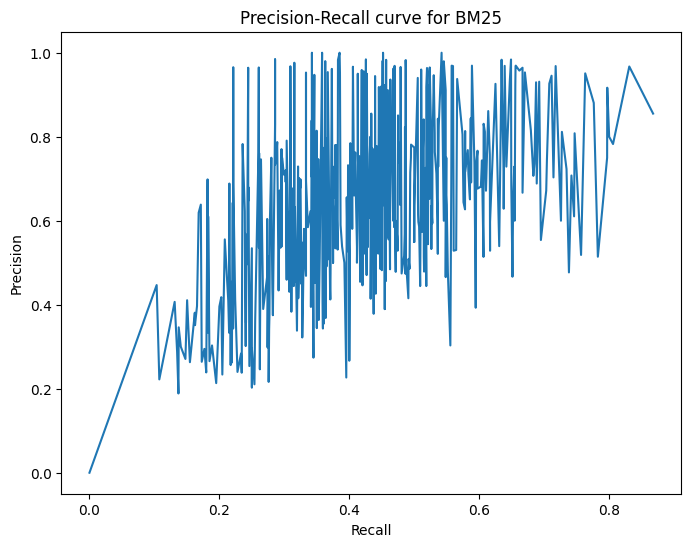


####### Time to process the category business with 510 documents: 
 
        - 10.099481105804443 seconds 

        - 0.01980290412902832 seconds per document
        


Average precision: 0.6422459716830485
Average recall: 0.4261569921855633
F1 score: 0.5123490308276619
Standard deviation of precision: 0.1989203483738531
Standard deviation of recall: 0.14694744252810735
Mean average precision: 0.6422459716830485


In [92]:
average_precision, average_recall, f1, std_precision, std_recall, m_a_p = evaluation("business", ix, max_sentences=5, max_characters=500, order=True, scoring_type="BM25")


print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"F1 score: {f1}")
print(f"Standard deviation of precision: {std_precision}")
print(f"Standard deviation of recall: {std_recall}")
print(f"Mean average precision: {m_a_p}")


### RRF vs Normal Summary 

The test will run on 10 documents and we will use all the metrics.

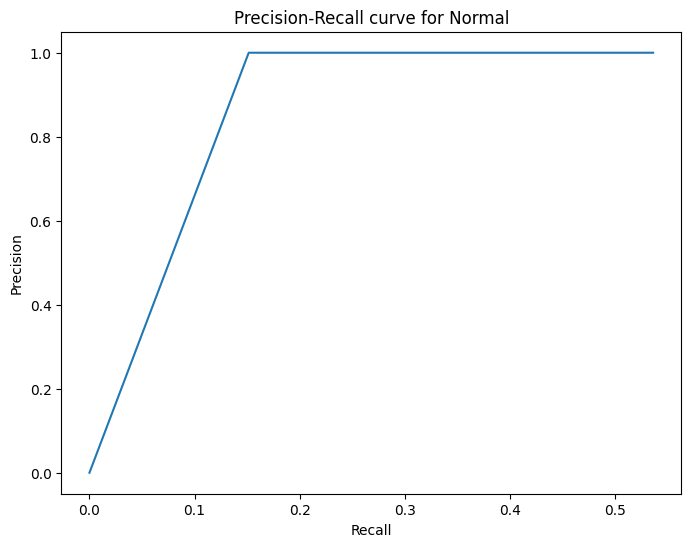


####### Time to process the category business with 10 documents: 
 
        - 0.25047993659973145 seconds 

        - 0.025047993659973143 seconds per document
        




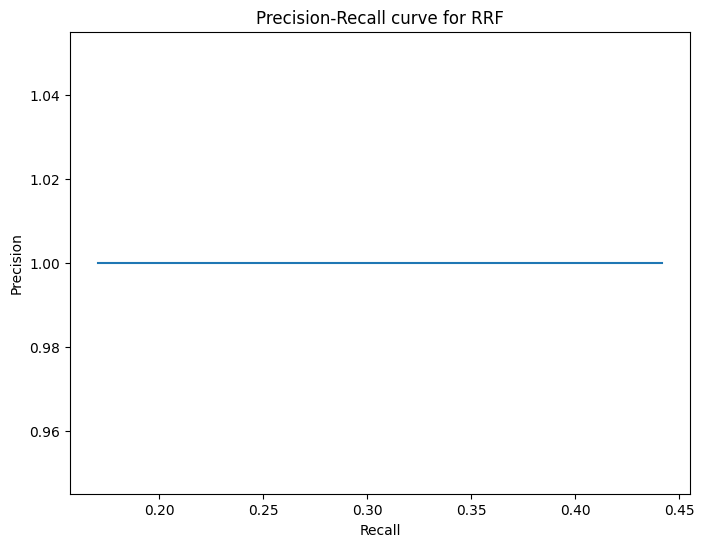


####### Time to process the category business with 10 documents: 
 
        - 0.2565946578979492 seconds 

        - 0.025659465789794923 seconds per document
        




In [94]:
politics_documents = [doc for doc in documents_paths if "politics" in doc][40:50]

normal_summaries = {}
rrf_summaries = {}

for pol in politics_documents:
    with open(pol, "r") as file:
        content = file.read()
        normal_summaries[pol] = summarization(content, 5, 500, True, ix, scoring_type="BM25")
        rrf_summaries[pol] = RRF_summary(pol, ix, 5, 500, True)

# Ok now we need to evaluate the summaries
real_politics_summaries = {}
for pol in politics_documents:
    with open(pol, "r") as file:
        content = file.read()
        real_politics_summaries[pol] = content

normal_average_precision, normal_average_recall, normal_f1, normal_std_precision, normal_std_recall, normal_m_a_p = evaluation_given_summaries(normal_summaries, real_politics_summaries, "Normal")
rrf_average_precision, rrf_average_recall, rrf_f1, rrf_std_precision, rrf_std_recall, rrf_m_a_p = evaluation_given_summaries(rrf_summaries, real_politics_summaries, "RRF")

normal = [normal_average_precision, normal_average_recall, normal_f1, normal_std_precision, normal_std_recall, normal_m_a_p]
rrf = [rrf_average_precision, rrf_average_recall, rrf_f1, rrf_std_precision, rrf_std_recall, rrf_m_a_p]


def pair_plot_metrics(normal, rrf):
    df = pd.DataFrame({
        "Normal": normal,
        "RRF": rrf
    }, index=["Average precision", "Average recall", "F1 score", "Standard deviation of precision", "Standard deviation of recall", "Mean average precision"])

    df.plot(kind="bar", figsize=(10, 8))
    plt.title("Comparison of metrics for normal and RRF summarization")
    plt.show()


def compare_metrics(normal, rrf):
    print(f"Normal average precision: {normal[0]}")
    print(f"RRF average precision: {rrf[0]}")
    print()
    print(f"Normal average recall: {normal[1]}")
    print(f"RRF average recall: {rrf[1]}")
    print()
    print(f"Normal F1 score: {normal[2]}")
    print(f"RRF F1 score: {rrf[2]}")
    print()
    print(f"Normal standard deviation osf precision: {normal[3]}")
    print(f"RRF standard deviation of precision: {rrf[3]}")
    print()
    print(f"Normal standard deviation of recall: {normal[4]}")
    print(f"RRF standard deviation of recall: {rrf[4]}")
    print()
    print(f"Normal mean average precision: {normal[5]}")
    print(f"RRF mean average precision: {rrf[5]}")

    pair_plot_metrics(normal, rrf)


Normal average precision: 0.9
RRF average precision: 1.0

Normal average recall: 0.25796875067904756
RRF average recall: 0.26631914731380907

Normal F1 score: 0.400998516540268
RRF F1 score: 0.42061931682663245

Normal standard deviation osf precision: 0.3
RRF standard deviation of precision: 0.0

Normal standard deviation of recall: 0.13888560094691116
RRF standard deviation of recall: 0.0838696090094526

Normal mean average precision: 0.9
RRF mean average precision: 1.0


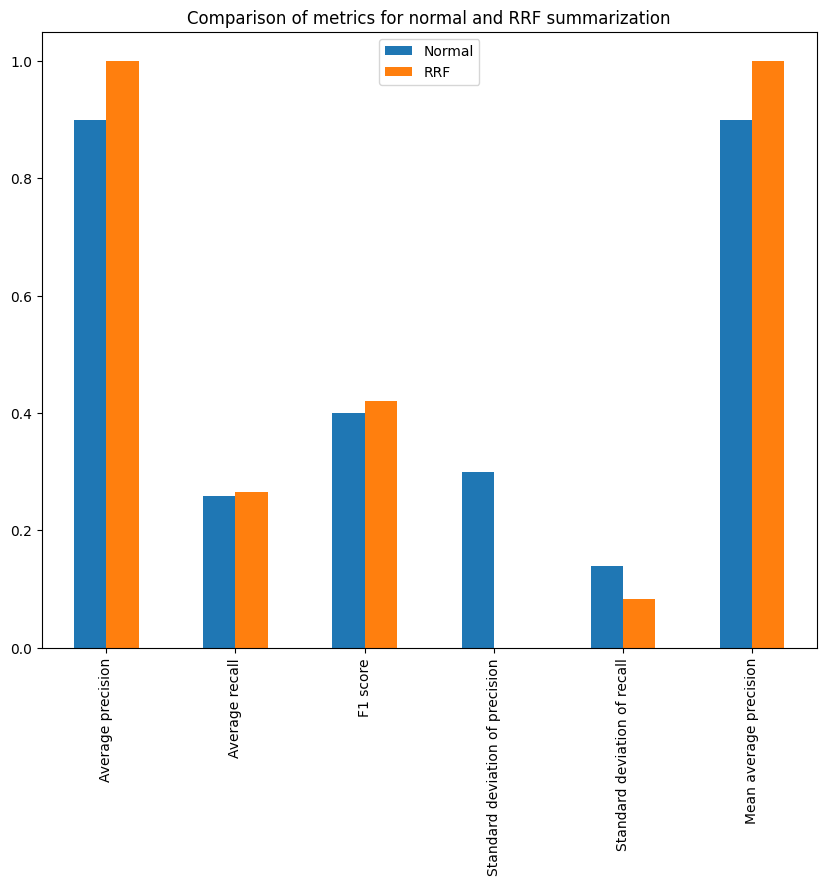

In [95]:
compare_metrics(normal, rrf)

Ok, looks like it works lol

## Test: MMR vs BM25

The test will be done over all the collection $D$ of documents and we will use all the metrics.
Probably this will take a while to run, so let's see how it goes.

In [100]:

normal_summaries = {}
mmr_summaries = {}

# We will run over all the documents
for doc in documents_paths:
    with open(doc, "r") as file:
        content = file.read()
        normal_summaries[doc] = summarization(content, 5, 500, True, ix, scoring_type="BM25")
        mmr_summaries[doc] = MMR(content, ix, 5, 500, True, 0.5)

# Ok now we need to evaluate the summaries
real_summaries = {}
for summary in summaries:
    with open(summary, "r") as file:
        content = file.read()
        real_summaries[summary] = content


In [99]:
normal_average_precision, normal_average_recall, normal_f1, normal_std_precision, normal_std_recall, normal_m_a_p = evaluation_given_summaries(normal_summaries, real_summaries, "Normal")
mmr_average_precision, mmr_average_recall, mmr_f1, mmr_std_precision, mmr_std_recall, mmr_m_a_p = evaluation_given_summaries(mmr_summaries, real_summaries, "MMR")

normal = [normal_average_precision, normal_average_recall, normal_f1, normal_std_precision, normal_std_recall, normal_m_a_p]
mmr = [mmr_average_precision, mmr_average_recall, mmr_f1, mmr_std_precision, mmr_std_recall, mmr_m_a_p]

compare_metrics(normal, mmr)

KeyError: '../BBC News Summary/News Articles\\business\\001.txt'

<H3>Part II: questions materials (optional)</H3>

**(1)** Corpus *D* and summaries *S* description.

In [29]:
#code, statistics and/or charts here

**(2)** Summarization performance for the overall and category-conditional corpora.

In [30]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>